In [1]:
# geopython env + mxnet1.6.0 env
import numpy as np
import pandas as pd
import imageio
import os
from scipy.stats import linregress
from scipy.stats.stats import pearsonr
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
import higra as hg
import scipy.ndimage as si
from skimage import measure
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
%matplotlib inline

# Instance segmentation post-processing

## Helper functions

In [2]:
def InstSegm(extent, boundary, t_ext=0.4, t_bound=0.2):
    """
    INPUTS:
    extent : extent prediction
    boundary : boundary prediction
    t_ext : threshold for extent
    t_bound : threshold for boundary
    OUTPUT:
    instances
    """

    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)

    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    input_hws[ext_binary == 0] = 1

    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean
    )

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights
    )
    
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound)
    
    instances[ext_binary == 0] = -1

    return instances

# Instance metrics

In [3]:
splits_df = pd.read_csv('../data/splits/sherrie10k_planetImagery_splits_20x20_4x-downsampled.csv')
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(5)
splits_df.head()

image_id        lat       lon   fold
0    00000  45.170360  3.531187   test
1    00001  49.557181  0.591338  train
2    00002  46.215638  4.184958   test
3    00003  45.694366  1.540555   test
4    00004  44.683271  2.670917  train

In [4]:
train_ids = splits_df[splits_df['fold'] == 'train']['image_id'].values
val_ids = splits_df[splits_df['fold'] == 'val']['image_id'].values
test_ids = splits_df[splits_df['fold'] == 'test']['image_id'].values

## IoU

In [5]:
def get_IoUs(extent_true, extent_pred, boundary_pred, t_ext=0.4, 
             t_bound=0.2, plot=False):
    
    # get predicted instance segmentation
    instances_pred = InstSegm(extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
    instances_pred = measure.label(instances_pred, background=-1)
    
    # get instances from ground truth label
    instances_true = extent_true
    # binary_true = extent_true > 0
    # instances_true = measure.label(binary_true, background=0, connectivity=1)
    
    # remove non-cropland
    # kernel = np.ones((2,2), np.uint8)
    # cropland_mask = si.binary_closing(binary_true, structure=kernel, 
    #                                   iterations=4, border_value=1)
    # instances_pred = instances_pred * cropland_mask
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(instances_true)
        ax[1].imshow(instances_pred)
        plt.show()
    
    # loop through true fields
    field_values = np.unique(instances_true)
    best_IoUs = []
    field_sizes = []
    
    for field_value in field_values:
        if field_value == 0:
            continue # move on to next value
            
        this_field = instances_true == field_value
        field_sizes.append(np.sum(this_field))
        
        # find predicted fields that intersect with true field
        intersecting_fields = this_field * instances_pred
        intersect_values = np.unique(intersecting_fields)
        
        intersect_fields = np.isin(instances_pred, intersect_values[1:])
        
        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))
            ax[0].imshow(this_field)
            ax[1].imshow(intersect_fields)
            plt.show()
        
        # compute IoU for each intersecting field
        field_IoUs = []
        for intersect_value in intersect_values:
            if intersect_value == 0:
                continue # move on to next value
            pred_field = instances_pred == intersect_value
            union = this_field + pred_field > 0
            intersection = (this_field * pred_field) > 0
            IoU = np.sum(intersection) / np.sum(union)
            field_IoUs.append(IoU)
    
        # take maximum IoU - this is the IoU for this true field
        if len(field_IoUs) > 0:
            best_IoUs.append(np.max(field_IoUs))
        else:
            best_IoUs.append(0)
    
    return best_IoUs, field_sizes

## Planet

### Hyperparameter tuning

#### Original resolution France FULL labels

In [6]:
consensus_exists = os.listdir('../results/full-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct/extent_predictions')
consensus_exists = [x[:5] for x in consensus_exists]
val_ids_overlap = [x for x in val_ids if x in consensus_exists]

In [15]:
# hyperparameter values
t_exts = np.linspace(0.2, 0.4, 5)
t_bounds = np.linspace(0.05, 0.15, 3)

# run for all test fields
image_ids = np.random.choice(val_ids_overlap, 100, replace=False)

# convert from full France labels to binary label
codes_to_keep = list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,28]

# Planet France
label_dir = '../data/planet/france/extent_labels/1250px/original_thickness2_for_IoU/'
results_dirs = [
    '../results/full-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct/',
]

for results_dir in results_dirs:
    print(results_dir.split('/')[4])
    mIoUs = []
    IoU_50s = []
    all_IoUs = []
    mFieldSizes = []
    all_FieldSizes = []
    
    for t_ext in t_exts:
        for t_bound in t_bounds:
            print("  t_ext: {}, t_bound: {}".format(t_ext, t_bound))
            IoUs = []
            field_sizes = []

            for i, image_id in enumerate(image_ids):
                if i % 100 == 0:
                    print("    ", i)
                # label_path = os.path.join(label_dir, '{}.png'.format(image_id))
                label_path = os.path.join(label_dir, '{}.npy'.format(image_id))
                if os.path.exists(label_path):
                    # example_truth = imageio.imread(label_path)[:256, :256]
                    # example_truth = np.array(np.isin(example_truth, codes_to_keep), dtype=np.uint8)
                    example_truth = np.load(label_path)[:256, :256]
                    extent_pred = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
                    boundary_pred = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))
                    img_IoUs, img_field_sizes = get_IoUs(example_truth, extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
                    IoUs = IoUs + img_IoUs
                    field_sizes = field_sizes + img_field_sizes

            mIoUs.append(np.median(IoUs))
            IoU_50s.append(np.sum(np.array(IoUs) > 0.5) / len(IoUs))
            all_IoUs.append(" ".join(["{:.4f}".format(x) for x in IoUs]))
            
            mFieldSizes.append(np.median(field_sizes))
            all_FieldSizes.append(" ".join([str(x) for x in field_sizes]))

    hp_df = pd.DataFrame({
        't_ext': np.repeat(t_exts, len(t_bounds)),
        't_bound': np.tile(t_bounds, len(t_exts)),
        'mIoU': mIoUs,
        'IoU_50': IoU_50s
    })
#     hp_df.to_csv(os.path.join(results_dir, 'IoU_hyperparameter_tuning.csv'), index=False)
    print(hp_df.iloc[hp_df['IoU_50'].idxmax()])

consensus_AprJulOct
  t_ext: 0.2, t_bound: 0.05
     0
  t_ext: 0.2, t_bound: 0.1
     0
  t_ext: 0.2, t_bound: 0.15
     0
  t_ext: 0.25, t_bound: 0.05
     0
  t_ext: 0.25, t_bound: 0.1
     0
  t_ext: 0.25, t_bound: 0.15
     0
  t_ext: 0.30000000000000004, t_bound: 0.05
     0
  t_ext: 0.30000000000000004, t_bound: 0.1
     0
  t_ext: 0.30000000000000004, t_bound: 0.15
     0
  t_ext: 0.35000000000000003, t_bound: 0.05
     0
  t_ext: 0.35000000000000003, t_bound: 0.1
     0
  t_ext: 0.35000000000000003, t_bound: 0.15
     0
  t_ext: 0.4, t_bound: 0.05
     0
  t_ext: 0.4, t_bound: 0.1
     0
  t_ext: 0.4, t_bound: 0.15
     0
t_ext      0.200000
t_bound    0.050000
mIoU       0.626632
IoU_50     0.627971
Name: 0, dtype: float64


#### Original resolution France

In [95]:
consensus_exists = os.listdir('../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct/extent_predictions')
consensus_exists = [x[:5] for x in consensus_exists]
val_ids_overlap = [x for x in val_ids if x in consensus_exists]

In [97]:
# hyperparameter values
t_exts = np.linspace(0.4, 0.6, 3)
t_bounds = np.linspace(0.0, 0.2, 3)

# run for all test fields
image_ids = np.random.choice(val_ids_overlap, 100, replace=False)

# convert from full France labels to binary label
codes_to_keep = list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,28]

# Planet France
label_dir = '../data/planet/france/extent_labels/1250px/original_thickness2_for_IoU/'
results_dirs = [
    '../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct/',
]

for results_dir in results_dirs:
    print(results_dir.split('/')[4])
    mIoUs = []
    IoU_50s = []
    all_IoUs = []
    mFieldSizes = []
    all_FieldSizes = []
    
    for t_ext in t_exts:
        for t_bound in t_bounds:
            print("  t_ext: {}, t_bound: {}".format(t_ext, t_bound))
            IoUs = []
            field_sizes = []

            for i, image_id in enumerate(image_ids):
                if i % 100 == 0:
                    print("    ", i)
                # label_path = os.path.join(label_dir, '{}.png'.format(image_id))
                label_path = os.path.join(label_dir, '{}.npy'.format(image_id))
                if os.path.exists(label_path):
                    # example_truth = imageio.imread(label_path)[:256, :256]
                    # example_truth = np.array(np.isin(example_truth, codes_to_keep), dtype=np.uint8)
                    example_truth = np.load(label_path)[:256, :256]
                    extent_pred = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
                    boundary_pred = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))
                    img_IoUs, img_field_sizes = get_IoUs(example_truth, extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
                    IoUs = IoUs + img_IoUs
                    field_sizes = field_sizes + img_field_sizes

            mIoUs.append(np.median(IoUs))
            IoU_50s.append(np.sum(np.array(IoUs) > 0.5) / len(IoUs))
            all_IoUs.append(" ".join(["{:.4f}".format(x) for x in IoUs]))
            
            mFieldSizes.append(np.median(field_sizes))
            all_FieldSizes.append(" ".join([str(x) for x in field_sizes]))

    hp_df = pd.DataFrame({
        't_ext': np.repeat(t_exts, len(t_bounds)),
        't_bound': np.tile(t_bounds, len(t_exts)),
        'mIoU': mIoUs,
        'IoU_50': IoU_50s
    })
    hp_df.to_csv(os.path.join(results_dir, 'IoU_hyperparameter_tuning.csv'), index=False)
    print(hp_df.iloc[hp_df['IoU_50'].idxmax()])

consensus_AprJulOct
  t_ext: 0.4, t_bound: 0.0
     0
  t_ext: 0.4, t_bound: 0.1
     0
  t_ext: 0.4, t_bound: 0.2
     0
  t_ext: 0.5, t_bound: 0.0
     0
  t_ext: 0.5, t_bound: 0.1
     0
  t_ext: 0.5, t_bound: 0.2
     0
  t_ext: 0.6, t_bound: 0.0
     0
  t_ext: 0.6, t_bound: 0.1
     0
  t_ext: 0.6, t_bound: 0.2
     0
t_ext      0.600000
t_bound    0.100000
mIoU       0.692308
IoU_50     0.667029
Name: 7, dtype: float64


1244340
1244340


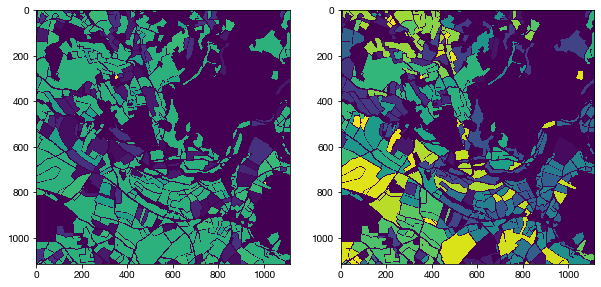

In [82]:
# confirm that the new labels (each field has its own unique id) 
# contains same fields as old labels (each field has crop type id)
label1 = imageio.imread('../data/planet/france/extent_labels/1250px/original_thickness2/00000.png')
label2 = np.load('../data/planet/france/extent_labels/1250px/original_thickness2_for_IoU/00000.npy')
print(np.sum((label1 > 0) == (label2 > 0)))
print(label1.shape[0] * label1.shape[1])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(label1)
ax[1].imshow(label2)
plt.show()

#### 2x+3x downsampled France

In [ ]:
import shutil

label_2x_dir = '../data/planet/france/extent_labels/1250px/2x_downsample_for_IoU/'
label_3x_dir = '../data/planet/france/extent_labels/1250px/3x_downsample_for_IoU/'
new_label_dir = '../data/planet/france/extent_labels/1250px/2x-3x_downsample_for_IoU/'
image_ids = sorted(os.listdir(label_2x_dir))

for image_id in image_ids:
    new_image_id = image_id[:5] + '-2x.npy'
    src = os.path.join(label_2x_dir, image_id)
    dst = os.path.join(new_label_dir, new_image_id)
    shutil.copyfile(src, dst)
    
    new_image_id = image_id[:5] + '-3x.npy'
    src = os.path.join(label_3x_dir, image_id)
    dst = os.path.join(new_label_dir, new_image_id)
    shutil.copyfile(src, dst)

In [102]:
consensus_exists = os.listdir('../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus_AprJulOct/extent_predictions')
consensus_exists = np.unique([x[:5] for x in consensus_exists])
val_ids_overlap_2x = [x + '-2x' for x in val_ids if x in consensus_exists]
val_ids_overlap_3x = [x + '-3x' for x in val_ids if x in consensus_exists]
val_ids_overlap = val_ids_overlap_2x + val_ids_overlap_3x

In [105]:
# hyperparameter values
t_exts = np.linspace(0.4, 0.6, 3)
t_bounds = np.linspace(0.0, 0.2, 3)

# run for all test fields
image_ids = np.random.choice(val_ids_overlap, 100, replace=False)

# convert from full France labels to binary label
codes_to_keep = list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,28]

# Planet France
label_dir = '../data/planet/france/extent_labels/1250px/2x-3x_downsample_for_IoU/'
results_dirs = [
    '../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus_AprJulOct/',
]

for results_dir in results_dirs:
    print(results_dir.split('/')[4])
    mIoUs = []
    IoU_50s = []
    all_IoUs = []
    mFieldSizes = []
    all_FieldSizes = []
    
    for t_ext in t_exts:
        for t_bound in t_bounds:
            print("  t_ext: {}, t_bound: {}".format(t_ext, t_bound))
            IoUs = []
            field_sizes = []

            for i, image_id in enumerate(image_ids):
                if i % 100 == 0:
                    print("    ", i)
                # label_path = os.path.join(label_dir, '{}.png'.format(image_id))
                label_path = os.path.join(label_dir, '{}.npy'.format(image_id))
                if os.path.exists(label_path):
                    # example_truth = imageio.imread(label_path)[:256, :256]
                    # example_truth = np.array(np.isin(example_truth, codes_to_keep), dtype=np.uint8)
                    example_truth = np.load(label_path)[:256, :256]
                    extent_pred = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
                    boundary_pred = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))
                    img_IoUs, img_field_sizes = get_IoUs(example_truth, extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
                    IoUs = IoUs + img_IoUs
                    field_sizes = field_sizes + img_field_sizes

            mIoUs.append(np.median(IoUs))
            IoU_50s.append(np.sum(np.array(IoUs) > 0.5) / len(IoUs))
            all_IoUs.append(" ".join(["{:.4f}".format(x) for x in IoUs]))
            
            mFieldSizes.append(np.median(field_sizes))
            all_FieldSizes.append(" ".join([str(x) for x in field_sizes]))

    hp_df = pd.DataFrame({
        't_ext': np.repeat(t_exts, len(t_bounds)),
        't_bound': np.tile(t_bounds, len(t_exts)),
        'mIoU': mIoUs,
        'IoU_50': IoU_50s
    })
    hp_df.to_csv(os.path.join(results_dir, 'IoU_hyperparameter_tuning.csv'), index=False)
    print(hp_df.iloc[hp_df['IoU_50'].idxmax()])

consensus_AprJulOct
  t_ext: 0.4, t_bound: 0.0
     0
  t_ext: 0.4, t_bound: 0.1
     0
  t_ext: 0.4, t_bound: 0.2
     0
  t_ext: 0.5, t_bound: 0.0
     0
  t_ext: 0.5, t_bound: 0.1
     0
  t_ext: 0.5, t_bound: 0.2
     0
  t_ext: 0.6, t_bound: 0.0
     0
  t_ext: 0.6, t_bound: 0.1
     0
  t_ext: 0.6, t_bound: 0.2
     0
t_ext      0.500000
t_bound    0.100000
mIoU       0.631579
IoU_50     0.629381
Name: 4, dtype: float64


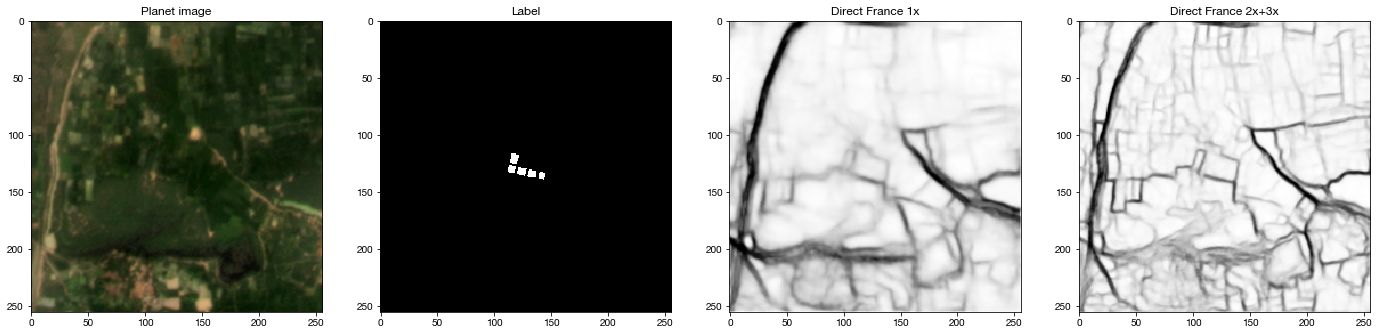

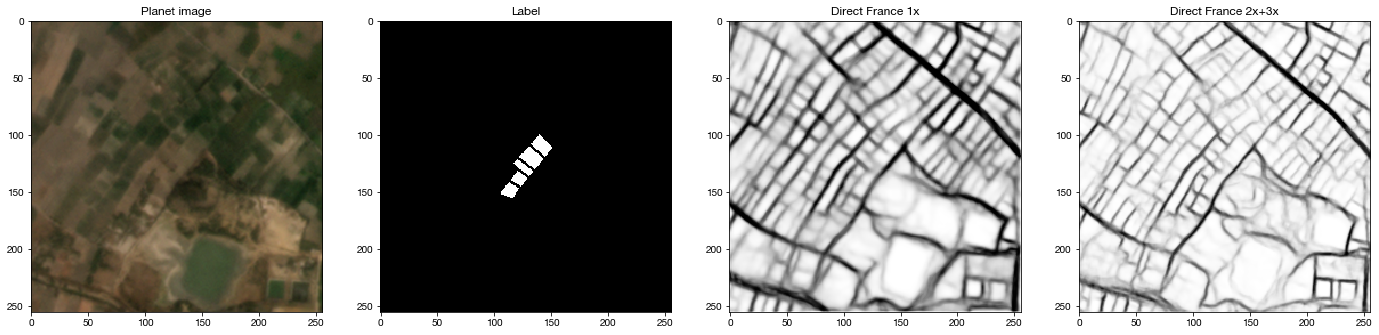

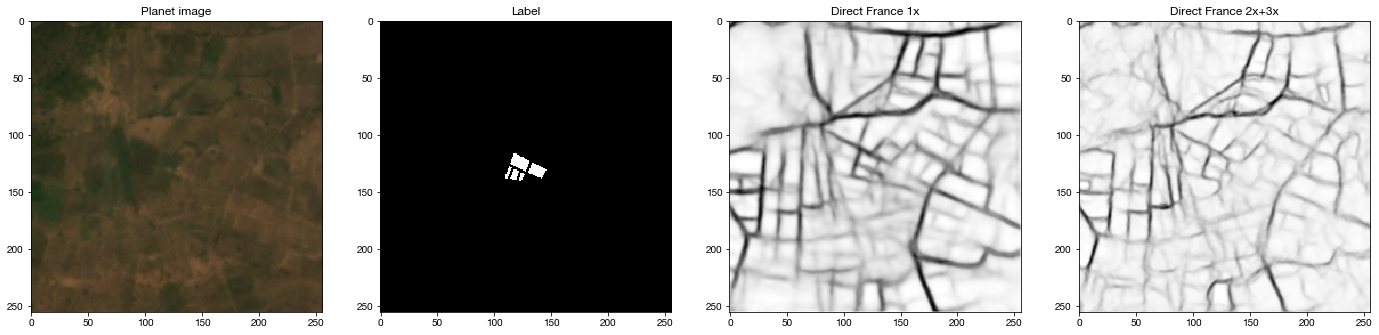

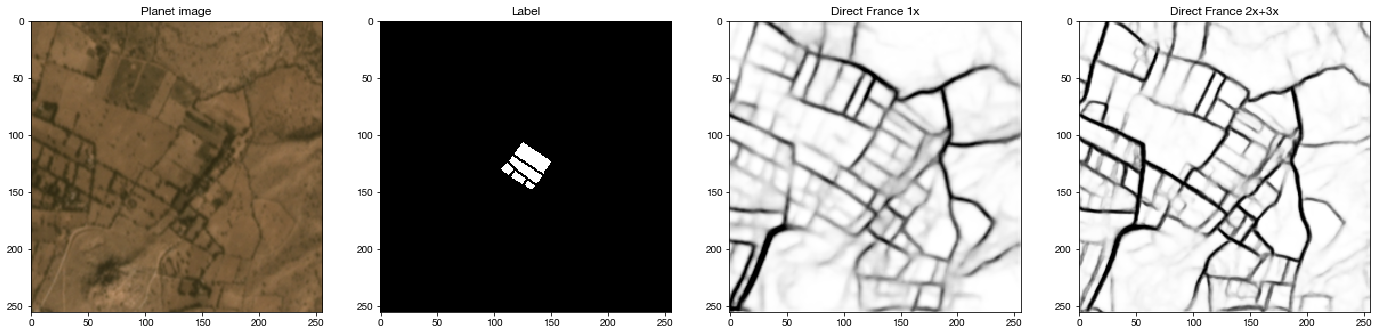

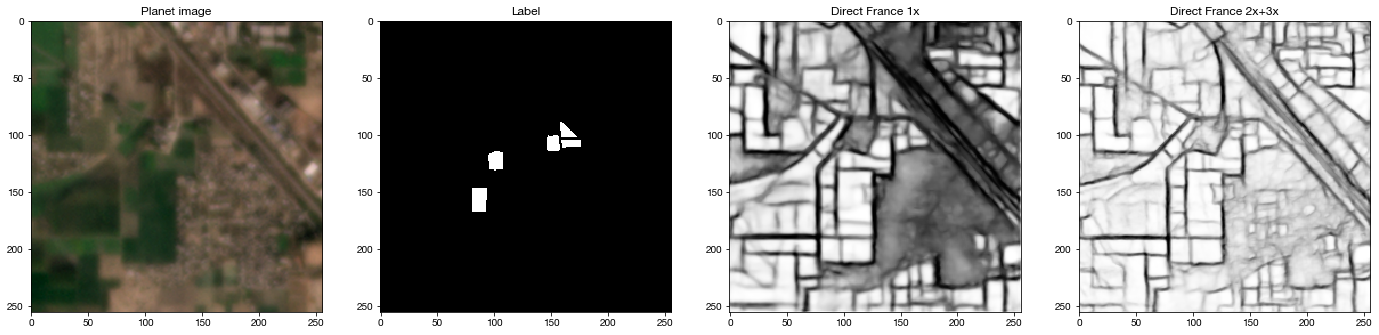

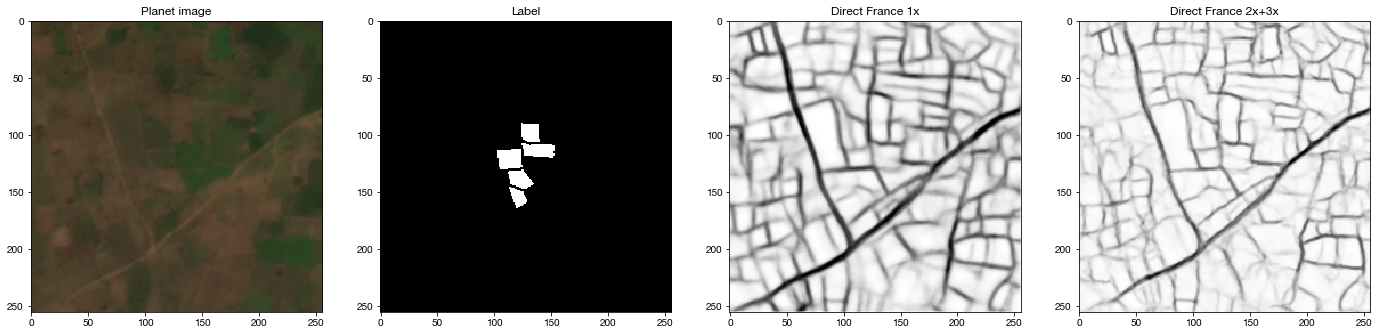

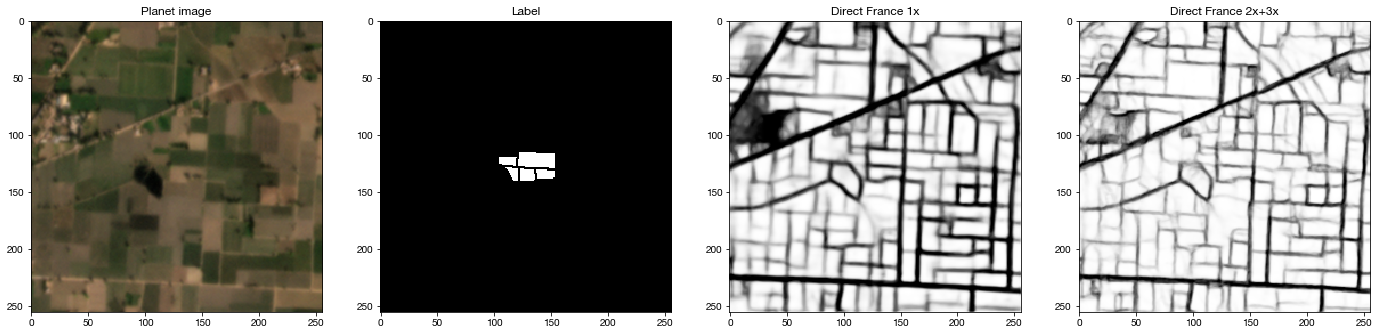

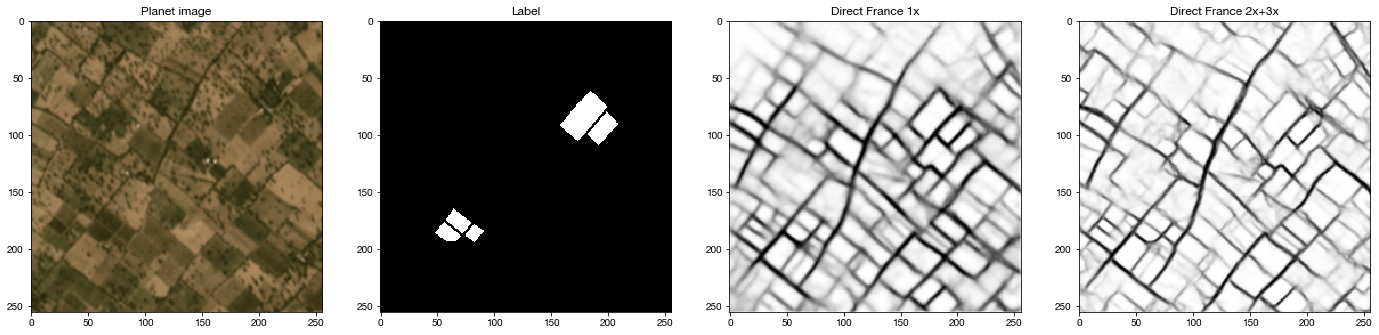

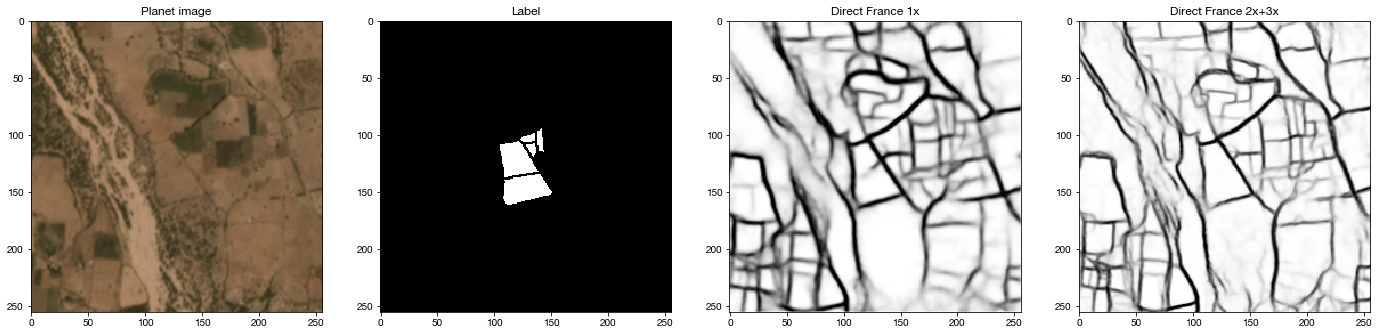

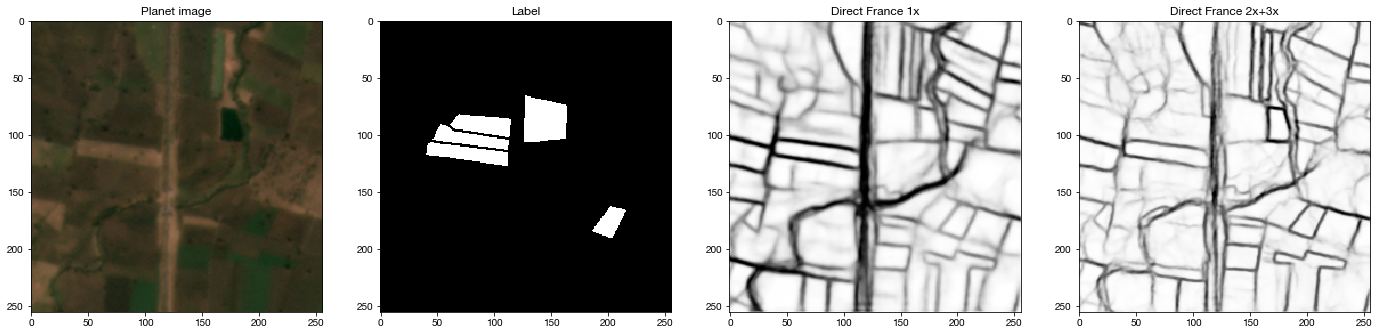

In [25]:
# for image_id in val_ids[:10]:
#     img = imageio.imread('../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged_val/2020_12/{}_2020_12.tif'.format(image_id))
#     label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_val/{}.png'.format(image_id))
#     pred1 = np.load('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/consensus/extent_predictions/{}.npy'.format(image_id))
#     pred2 = np.load('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus/extent_predictions/{}.npy'.format(image_id))

#     fig, ax = plt.subplots(1, 4, figsize=(24,6))
#     ax[0].imshow(img)
#     ax[1].imshow(label, cmap='Greys_r')
#     ax[2].imshow(pred1, cmap='Greys_r')
#     ax[3].imshow(pred2, cmap='Greys_r')
#     ax[0].set_title('Planet image')
#     ax[1].set_title('Label')
#     ax[2].set_title('Direct France 1x')
#     ax[3].set_title('Direct France 2x+3x')
#     plt.show()

In [106]:
# Planet France: Best hyperparameters
results_dirs = [
    '../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct/',
    '../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus_AprJulOct/'
]
for results_dir in results_dirs:
    print(results_dir.split('/')[4])
    hp_df = pd.read_csv(os.path.join(results_dir, 'IoU_hyperparameter_tuning.csv'))
    print(hp_df.iloc[hp_df['mIoU'].idxmax()])

consensus_AprJulOct
t_ext      0.600000
t_bound    0.100000
mIoU       0.692308
IoU_50     0.667029
Name: 7, dtype: float64
consensus_AprJulOct
t_ext      0.600000
t_bound    0.200000
mIoU       0.647059
IoU_50     0.619588
Name: 8, dtype: float64


### Run on all test set

In [18]:
# run for all test fields
def get_Planet_test_set_IoUs(test_ids, 
                             model_name='fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct/',
                             label_dir='../data/planet/france/extent_labels/1250px/original_thickness2_for_IoU/',
                             t_ext=0.15, t_bound=0.2,
                             codes_to_keep=list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,28]):
    image_ids = test_ids
    # results_dir = '../results/partial-france/{}'.format(model_name)
    results_dir = '../results/full-france/{}'.format(model_name)

    IoUs = []
    field_sizes = []

    for i, image_id in enumerate(image_ids):
        if i % 100 == 0:
            print(i)
        # label_path = os.path.join(label_dir, '{}.png'.format(image_id))
        label_path = os.path.join(label_dir, '{}.npy'.format(image_id))
        if os.path.exists(label_path):
            # example_truth = imageio.imread(label_path)[:256,:256]
            # example_truth = np.array(np.isin(example_truth, codes_to_keep), dtype=np.uint8)
            example_truth = np.load(label_path)[:256,:256]
            extent_pred = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
            boundary_pred = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))
            img_IoUs, img_field_sizes = get_IoUs(example_truth, extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
            IoUs = IoUs + img_IoUs
            field_sizes = field_sizes + img_field_sizes
            
    return IoUs, field_sizes

#### France 1x FULL labels

In [20]:
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct/'
t_ext = 0.35
t_bound = 0.1
IoUs, field_sizes = get_Planet_test_set_IoUs(
    test_ids=test_ids, 
    model_name=model_name, 
    t_ext=t_ext, 
    t_bound=t_bound
)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/full-france/{}/IoU.csv'.format(model_name),
    index=False)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [21]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.667
IoU_50 = 0.632


#### France 1x

In [89]:
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct/'
t_ext = 0.5
t_bound = 0.1
IoUs, field_sizes = get_Planet_test_set_IoUs(
    test_ids=test_ids, 
    model_name=model_name, 
    t_ext=t_ext, 
    t_bound=t_bound
)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/partial-france/{}/IoU.csv'.format(model_name),
    index=False)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [90]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.696
IoU_50 = 0.680


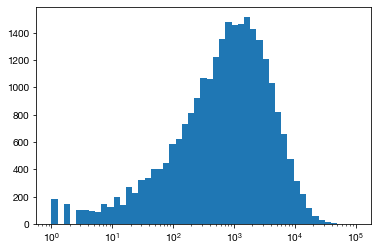

In [91]:
plt.hist(field_sizes, bins=np.logspace(0, 5))
plt.xscale('log')
plt.show()

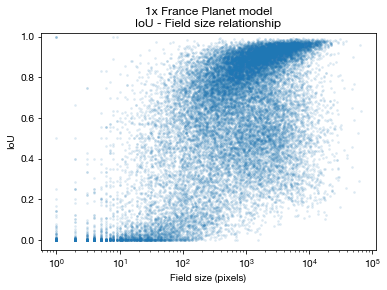

In [92]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.xlabel('Field size (pixels)')
plt.ylabel('IoU')
# plt.xlim([0.7, 5500])
plt.ylim([-0.05, 1.02])
plt.title('1x France Planet model\nIoU - Field size relationship')
plt.show()

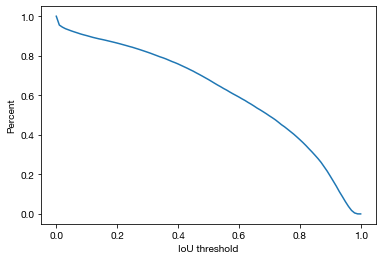

In [93]:
IoU_thresholds = np.linspace(0,1,101)
percent_of_fields = []

for IoU_threshold in IoU_thresholds:
    percent_of_fields.append(
        np.sum(np.array(IoUs) >= IoU_threshold) / len(IoUs))
    
# IoU curve
plt.plot(IoU_thresholds, percent_of_fields)
plt.xlabel('IoU threshold')
plt.ylabel('Percent')
plt.show()

In [66]:
# before tiny fields artifact bug was fixed
# print("mIoU   = {:0.3f}".format(np.median(IoUs)))
# print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.519
IoU_50 = 0.511


In [67]:
# removing fields that are < 10 pixels
more_than_10px = np.array(field_sizes) >= 10
IoUs_10px = np.array(IoUs)[more_than_10px]
print("mIoU   = {:0.3f}".format(np.median(IoUs_10px)))
print("IoU_50 = {:0.3f}".format(np.sum(IoUs_10px >= 0.5) / len(IoUs_10px)))

mIoU   = 0.722
IoU_50 = 0.678


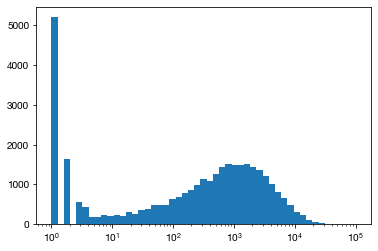

In [61]:
# before tiny fields artifact bug was fixed
plt.hist(field_sizes, bins=np.logspace(0, 5))
plt.xscale('log')
plt.show()

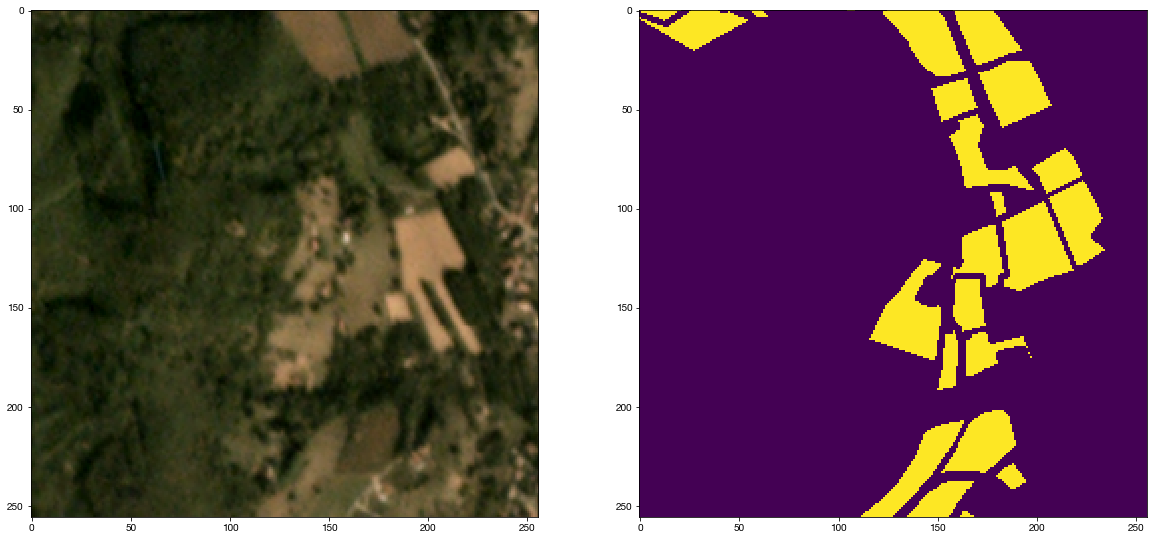

In [48]:
# get instances from ground truth label
image_id = '03484'
img = imageio.imread('../data/planet/france/1250px/original/{}_2019_10.tif'.format(image_id))[:256,:256]
extent_true = imageio.imread('../data/planet/france/extent_labels/1250px/original_thickness2/{}.png'.format(image_id))[:256,:256]
binary_true = extent_true > 0
instances_true = measure.label(binary_true, background=0, connectivity=1)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img)
ax[1].imshow(binary_true)
plt.show()

####  France 2x+3x downsampled

In [107]:
consensus_exists = os.listdir('../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus_AprJulOct/extent_predictions')
consensus_exists = np.unique([x[:5] for x in consensus_exists])
test_ids_overlap_2x = [x + '-2x' for x in test_ids if x in consensus_exists]
test_ids_overlap_3x = [x + '-3x' for x in test_ids if x in consensus_exists]
test_ids_overlap = test_ids_overlap_2x + test_ids_overlap_3x

In [111]:
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus_AprJulOct'
t_ext = 0.6
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(
    test_ids=test_ids_overlap, 
    model_name=model_name,
    label_dir='../data/planet/france/extent_labels/1250px/2x-3x_downsample_for_IoU/',
    t_ext=t_ext, 
    t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/partial-france/{}/IoU.csv'.format(model_name),
    index=False)

In [112]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.646
IoU_50 = 0.623


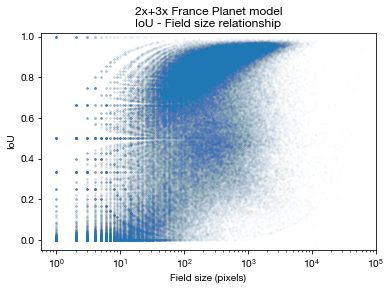

In [117]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.01, s=3)
plt.xscale('log')
plt.xlabel('Field size (pixels)')
plt.ylabel('IoU')
# plt.xlim([0.7, 5500])
plt.ylim([-0.05, 1.02])
plt.title('2x+3x France Planet model\nIoU - Field size relationship')
plt.show()

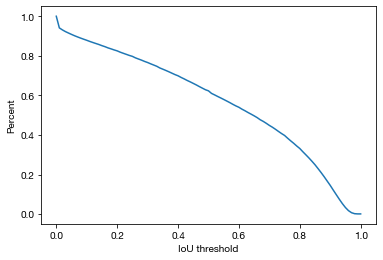

In [114]:
IoU_thresholds = np.linspace(0,1,101)
percent_of_fields = []

for IoU_threshold in IoU_thresholds:
    percent_of_fields.append(
        np.sum(np.array(IoUs) >= IoU_threshold) / len(IoUs))
    
# IoU curve
plt.plot(IoU_thresholds, percent_of_fields)
plt.xlabel('IoU threshold')
plt.ylabel('Percent')
plt.show()

## Visualize images and labels

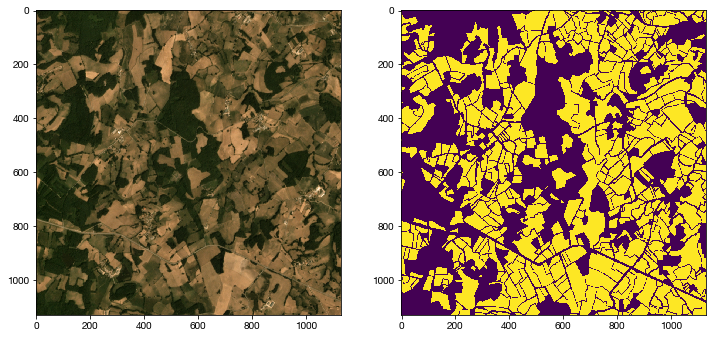

In [90]:
img = imageio.imread('../data/planet/france/1250px/original/08171_2019_07.tif')
label = imageio.imread('../data/planet/france/extent_labels/1250px/original_thickness2/08171.png')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[1].imshow(label > 0)
plt.show()

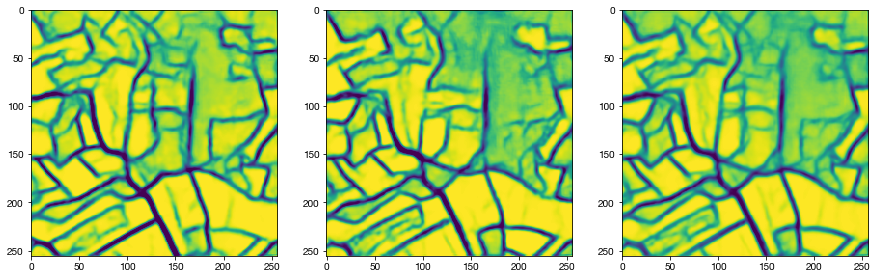

In [93]:
extent_2019_04 = np.load('../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/2019_04/extent_predictions/08171_2019_04.npy')
extent_2019_07 = np.load('../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/2019_07/extent_predictions/08171_2019_07.npy')
extent_consensus = np.load('../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/consensus_AprJulOct/extent_predictions/08171.npy')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(extent_2019_04)
ax[1].imshow(extent_2019_07)
ax[2].imshow(extent_consensus)
plt.show()

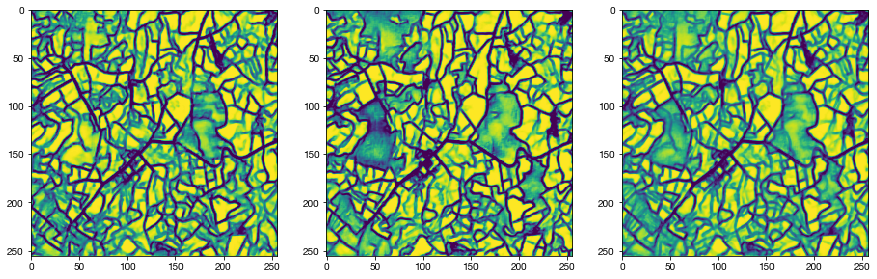

In [96]:
extent_2019_04 = np.load('../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/2019_04/extent_predictions/08171_2019_04-3x.npy')
extent_2019_07 = np.load('../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/2019_07/extent_predictions/08171_2019_07-3x.npy')
extent_consensus = np.load('../results/partial-france/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus_AprJulOct/extent_predictions/08171-3x.npy')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(extent_2019_04)
ax[1].imshow(extent_2019_07)
ax[2].imshow(extent_consensus)
plt.show()